In [1]:
using LinearAlgebra
using Statistics
using Plots
using BenchmarkTools

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278
┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1278


In [2]:
# helper methods
function symmetric_matrix(dim::Integer, show_matrix::Bool=false)::Matrix
    A = ones(dim,dim);
    for i = 1:dim
        for j = 1:i
            A[i,j] = rand(1:50);
            A[j,i] = A[i,j];
        end
    end
    if show_matrix
        display(A);
    end
    return A;
end

# we might change it to just rand(dim,dim)
function random_matrix(dim::Integer, show_matrix::Bool=false)::Matrix
    A = ones(dim, dim);
    for i = 1:dim
        for j = 1:dim
            A[i,j] = rand(1:50);
        end
    end
    if show_matrix
        display(A);
    end
    return A
end

function diagonal_matrix(dim::Integer)::Matrix
    Diag = ones(dim,dim)
    return Diagonal(Diag)
end

function eye(dim::Integer)::Matrix
    return Matrix{Float64}(I,n,n);
end


function custom_cond(λₘₐₓ, λₘᵢₙ)
    return sqrt(λₘₐₓ/λₘᵢₙ)
end

custom_cond (generic function with 1 method)

# Metoda potęgowa

Poniżej przygotowana jest funkcja do metody iteracji prostej (metoda potęgowa), dzięki której można wyznaczyć największą co do modułu wartość własną, czyli promień spektralny macierzy, który opisany jest wzorem:
## $$\rho(A) = |\lambda_{max}| = \lim_{i \to \infty} \frac{||t_{i+1}||_{\infty}}{||t_{i}||_{\infty}}$$

Przy założeniu, że dowolny wektor początkowy t_{0} != 0, do uzyskania promienia spektralnego prowadzą iteracje postaci:
## $$t_{i+1} = At_{i},\ i=0,1,2...$$



In [3]:
function power_eigen(A::Matrix, iterations::Integer)::Array
    n = size(A, 1);
    x = ones(n,1);
    x1 = x;
    
    for i = 1:iterations
        x1 = x;
        x = A * x;
        x = x / norm(x);
    end
    return x' * A * x1 / (x' * x1);
end

function power_eigen_min(A::Matrix, iterations::Integer)::Array
    n = size(A, 1);
    x = ones(n,1);
    x1 = x;
    for i = 1:iterations
        x1 = x;
        x = A \ x;
        x = x / norm(x);
    end

    return x' * A * x1 / (x' * x1);
end

power_eigen_min (generic function with 1 method)

In [4]:
A = symmetric_matrix(5);
#A = random_matrix(5);
#A = [22 21 -8 4; 21 49 11 39; -8 11 60 -19; 4 39 -19 135]
λₘₐₓ = power_eigen(A, 20);
λₘᵢₙ = power_eigen_min(A,20);
display(λₘₐₓ);
display(λₘᵢₙ);
e, v = eigen(A);
display(e);

1×1 Array{Float64,2}:
 132.79538323368703

1×1 Array{Float64,2}:
 -196.7038373434142

5-element Array{Float64,1}:
 -55.189860333531826
  -9.75488326867979
   9.549966970664329
  44.59939339786011
 132.79538323368695

In [5]:
# benchmark time for above Matrix
@btime  power_eigen(A, 20); # λₘₐₓ
@btime  power_eigen_min(A,20); # λₘᵢₙ

  6.640 μs (47 allocations: 5.72 KiB)
  18.000 μs (87 allocations: 13.84 KiB)


Jak widać z wyniku wykonania powyższego kodu, uzyskaliśmy największą co do modułu wartość własną macierzy. Ta wartość zgadza sięz wartością otrzymaną za pomocą metody eigen(A). Za pomocą metody potęgowej można również wyznaczyć najmniejszą co do modułu wartość własną macierzy. Korzysta się z twierdzenia dotyczącego przesunięcia spektrum macierzy:<br />
### "Jeżeli $\lambda$ jest wartością własną macierzy A, to $\lambda + r$ jest wartością własną macierzy $A + \tau I$"
Należy pamiętać, że twierdzenie ma zastosowanie dla macierzy symetrycznych i dodatnio określonych. Po zastosowaniu przesunięcia $B = A - \lambda_{max}I$ można ponownie zastosować metodę iteracji prostej dla macierzy B zbieżną do największej co do modułu wartości własnej $\lambda = \lambda_{min}-\lambda_{max}$. Stąd można wyznaczyć $\lambda_{min}$.

In [6]:
B = A' * A;
λₘₐₓ = power_eigen(B, 50);
n = size(A,1);
B_min = B - λₘₐₓ .* eye(n);
lambda_dash = power_eigen(B_min, 50);
λₘᵢₙ = lambda_dash + λₘₐₓ;

Mając największą i najmniejszą wartość własną macierzy, można wyznaczyć współczynnik uwarunkowania macierzy:
$$cond(A)=\sqrt{\frac{\lambda_{max}(A^TA)}{\lambda_{min}(A^TA)}}$$
We wzorze przyjęto, że macierz A jest symetryczna, co oznacza, że $A=A^T$, ewentualnie można macierz wejściową doprowadzić do postaci symetrycznej stosując wzór $B = A^TA$

In [7]:
value = custom_cond(λₘₐₓ, λₘᵢₙ)
print(value)

cond(A)

[13.690770706468882]

13.905323823800417

# Metoda Jacobiego

In [8]:
function jacobi_eigen(A::Matrix, iterations::Integer)::Matrix
    n = size(A,1);
    for i = 1:iterations
        s,t = maxst(A);
        
        d = √((A[s,s] - A[t,t])^2 + 4 * A[s,t]^2);
        sin2t = 2 * A[s,t] / d;
        cos2t = (A[s,s] - A[t,t]) / d;
        dt = sqrt(2 * (1 + cos2t));
        sint = abs(sin2t) / dt;
        cost = abs((1 + cos2t) / dt);
        cost = sign(A[s,t]) * cost;

        R = diagonal_matrix(n);
        R[s,s] = cost;
        R[t,t] = cost;
        R[s,t] = -sint;
        R[t,s] = sint;
        
        A = R' * A * R; 
        
    end
    return A
end

function maxst(A::Matrix)::Tuple{Integer,Integer}
    s = 1;
    t = 2;
    n = size(A,1);
    for c = 2:n
        for r = 1:c-1
            if abs(A[r,c]) > abs(A[s,t])
                s = r;
                t = c;
            end
        end
    end
    return s, t
end

maxst (generic function with 1 method)

In [9]:
#F = [12 6 -6 1; 6 16 2 100; -6 2 16 1 ;1 100 1 4];
#F = rand(4,4);
F = symmetric_matrix(5,true)
FJ = jacobi_eigen(F, 15);

n = size(FJ,1);
FJ = Diagonal(FJ)

display(FJ)
e,v = eigen(F);
display(e)


5×5 Array{Float64,2}:
 49.0  20.0  19.0  23.0  30.0
 20.0  45.0  21.0  45.0   2.0
 19.0  21.0  37.0  17.0  30.0
 23.0  45.0  17.0  39.0  42.0
 30.0   2.0  30.0  42.0  48.0

5×5 Diagonal{Float64,Array{Float64,1}}:
 144.921    ⋅        ⋅        ⋅         ⋅ 
    ⋅     47.5288    ⋅        ⋅         ⋅ 
    ⋅       ⋅      25.8529    ⋅         ⋅ 
    ⋅       ⋅        ⋅      21.2464     ⋅ 
    ⋅       ⋅        ⋅        ⋅      -21.5494

5-element Array{Float64,1}:
 -21.551383597831347
  21.24794701335503
  25.850285552665326
  47.52997564206508
 144.9231753897463

In [10]:
# benchmark time for above Matrix
@btime jacobi_eigen(F, 15);

  11.000 μs (75 allocations: 18.75 KiB)


# QR algorithm

In [11]:
function QR_eigen(A::Matrix, iterations::Integer)::Matrix
    for k = 1:iterations
        Q, R = mgs(A);
        A = R * Q;
    end
    return A;
end

function mgs(A::Matrix)::Tuple{Matrix, Matrix}
    n = size(A,1);
    R = zeros(n,n);
    Q = zeros(n,n);
    for j = 1:n
        v = A[:,j];
        for i = 1:j-1
            R[i,j] = Q[:,i]' * v;
            v = v - R[i,j] * Q[:,i];
        end
        R[j,j] = norm(v);
        Q[:,j] = v / R[j,j];
    end

    return Q, R;
end

mgs (generic function with 1 method)

In [12]:
A = symmetric_matrix(5);
AQR = QR_eigen(A, 30);
Diag = Diagonal(AQR);
display(Diag);

e, v = eigen(A);
display(e)

5×5 Diagonal{Float64,Array{Float64,1}}:
 145.55     ⋅        ⋅        ⋅        ⋅ 
    ⋅    -45.2999    ⋅        ⋅        ⋅ 
    ⋅       ⋅      39.8398    ⋅        ⋅ 
    ⋅       ⋅        ⋅      11.3731    ⋅ 
    ⋅       ⋅        ⋅        ⋅      -6.46296

5-element Array{Float64,1}:
 -48.66569496351417
  -6.462956106467367
  11.37306559805679
  43.205543481303565
 145.55004199062083

In [13]:
@btime QR_eigen(A, 30);

  83.900 μs (1590 allocations: 212.81 KiB)


# Badania

Poniższe wykresy prezentują zbieżność tylko dla największych wartości własnych, ponieważ metoda potęgowa wyznacza tylko pojedynczą wartość.

In [39]:
function plot_eigenvalues(PlotA::Matrix, min_iterations::Integer, max_iterations::Integer, show_all_in_one::Bool=false, err::Bool=false)
    if max_iterations < min_iterations
        return
    end

    x = min_iterations:max_iterations;
    results_power = zeros(0);
    results_jacobi = zeros(0);
    results_qr = zeros(0);
    if !err
        results_eig = zeros(0);
    end
    e, v = eigen(PlotA);
    eigen_lambda = maximum(abs, e);
    
    for i = min_iterations:max_iterations
        #power method
        val = power_eigen(PlotA,i);
        if err
            val = abs(eigen_lambda - val[1]);
        end
        append!(results_power, val);
    
        # jacobi algorithm
        PlotAJ = jacobi_eigen(PlotA, i);
        PlotAJ = Diagonal(PlotAJ);
        val = maximum(abs, PlotAJ);
        if err
            val = abs(eigen_lambda - val[1]);
        end
        append!(results_jacobi, val);
    
        # QR algorithm
        PlotAQR = QR_eigen(PlotA, i);
        PlotAQR = Diagonal(PlotAQR);
        val = maximum(abs, PlotAQR);
        if err
            val = abs(eigen_lambda - val[1]);
        end
        append!(results_qr, val);
        
        # julia eigen()
        if !err
            append!(results_eig, eigen_lambda)
        end
    end
    
    if err
        results = hcat(results_power, results_jacobi, results_qr);
        plot_all = plot(x, results, title= "Lambda max error", label=["power" "jacobi" "QR"], xlabel="iteracje", ylabel="błąd lambda");
        results = results_power;
        plot_power = plot(x, results, title= "Lambda max error", label="power", xlabel="iteracje", ylabel="błąd lambda");
        results = results_jacobi;
        plot_jacobi = plot(x, results, title= "Lambda max error", label="jacobi", xlabel="iteracje", ylabel="błąd lambda");
        results = results_qr;
        plot_qr = plot(x, results, title= "Lambda max error", label="QR", xlabel="iteracje", ylabel="błąd lambda");
    else
        results = hcat(results_eig, results_power, results_jacobi, results_qr);
        plot_all = plot(x, results, title= "Lambda max", label=["eigen" "power" "jacobi" "QR"], xlabel="iteracje", ylabel="wartosc lambda", ylim=(eigen_lambda*0.25, eigen_lambda*1.2));
        results = hcat(results_eig, results_power);
        plot_power = plot(x, results, title= "Lambda max", label=["eigen" "power"], xlabel="iteracje", ylabel="wartosc lambda");
        results = hcat(results_eig, results_jacobi);
        plot_jacobi = plot(x, results, title= "Lambda max", label=["eigen" "jacobi"], xlabel="iteracje", ylabel="wartosc lambda");
        results = hcat(results_eig, results_qr);
        plot_qr = plot(x, results, title= "Lambda max", label=["eigen" "QR"], xlabel="iteracje", ylabel="wartosc lambda");
    end
    if !show_all_in_one
        #show plots separate 
        display(plot_all);
        display(plot_power);
        display(plot_jacobi);
        display(plot_qr);
    else
        # all plots together
        all_plots = plot(plot_all, plot_power, plot_jacobi, plot_qr, size = (800,800), layout = grid(4, 1, heights=[0.25 , 0.25, 0.25, 0.25]));
        display(all_plots);
    end
end


plot_eigenvalues (generic function with 4 methods)

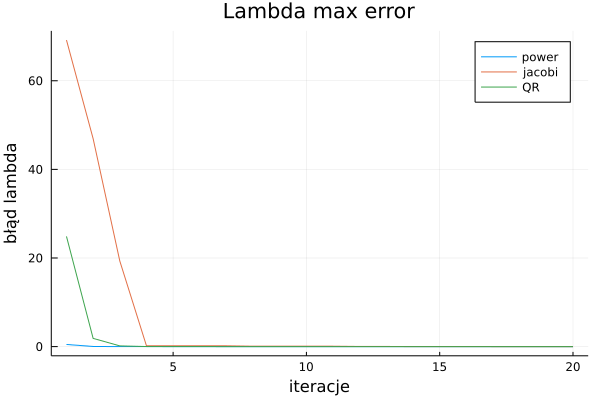

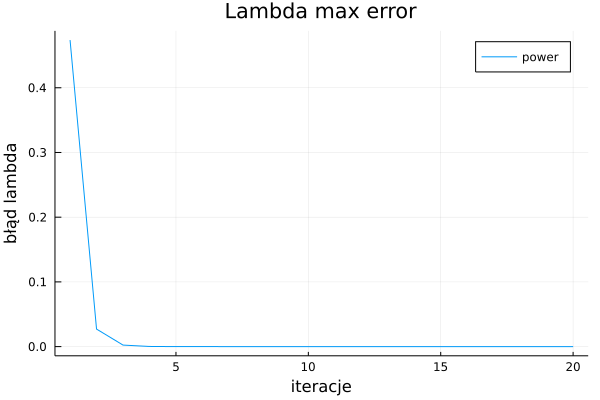

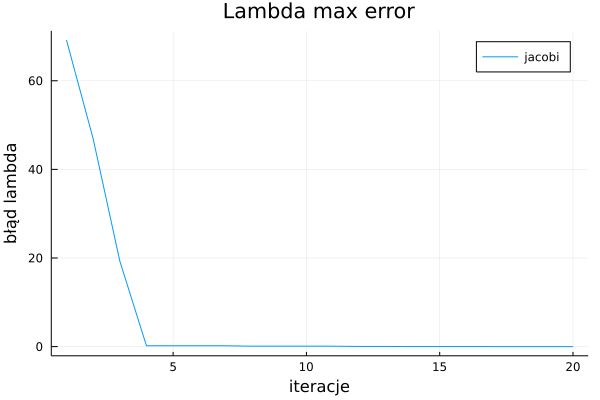

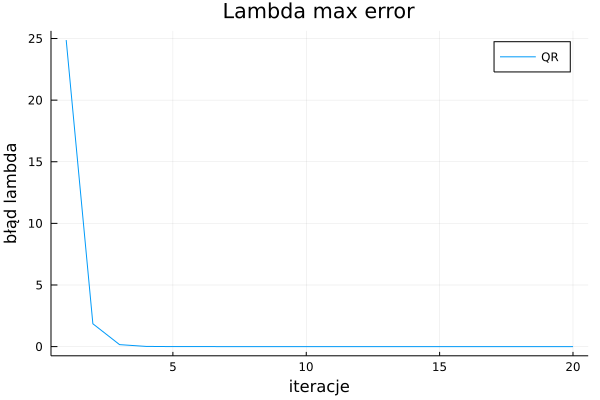

In [40]:
A = symmetric_matrix(5);
plot_eigenvalues(A, 1, 20, false, true);

## Przypadki testowe

metoda potęgowa - macierze o elementach i wartościach własnych rzeczywistych<br />
metoda Jacobiego - macierze symetryczne (w tym hermitowskie)<br />
algorytm QR - macierze niesymetryczne

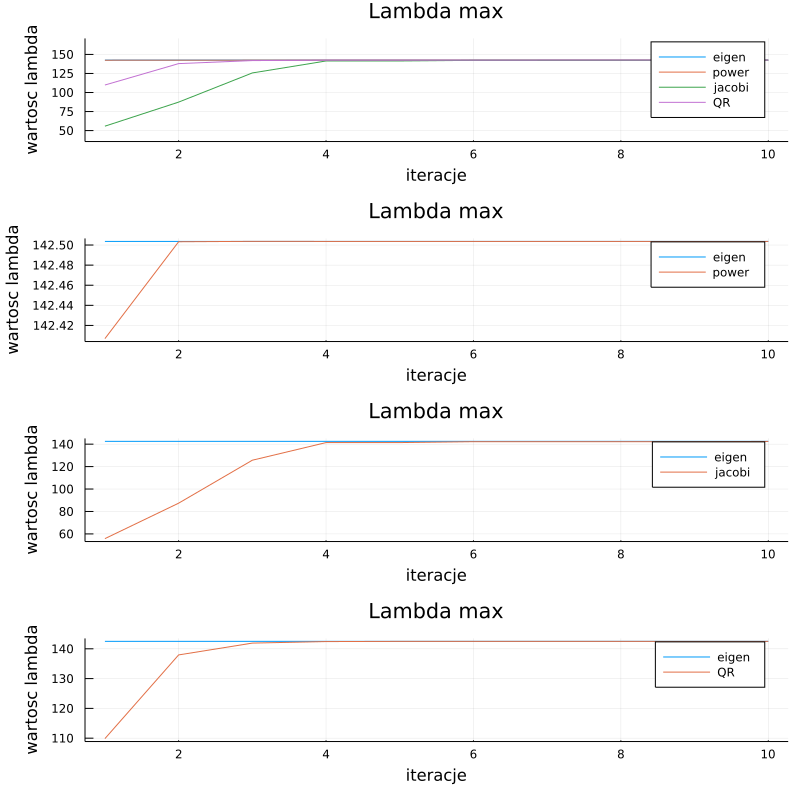

  0.089376 seconds (120.87 k allocations: 5.465 MiB)


In [41]:
Test1 = symmetric_matrix(5)
@time plot_eigenvalues(Test1, 1, 10, true)

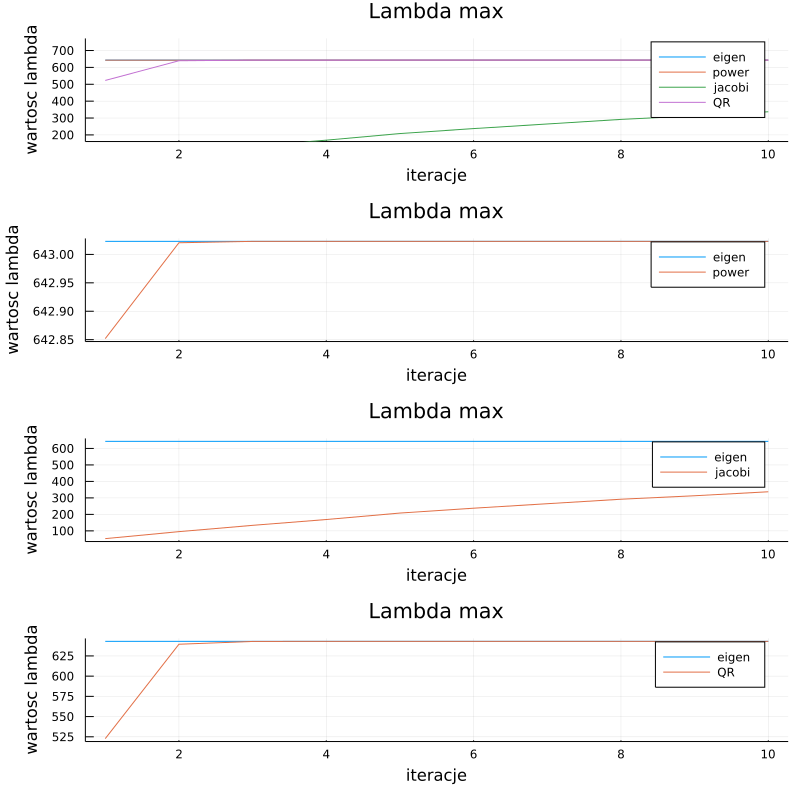

  0.096534 seconds (186.50 k allocations: 25.884 MiB)


In [42]:
Test2 = symmetric_matrix(25)
@time plot_eigenvalues(Test2, 1, 10, true)

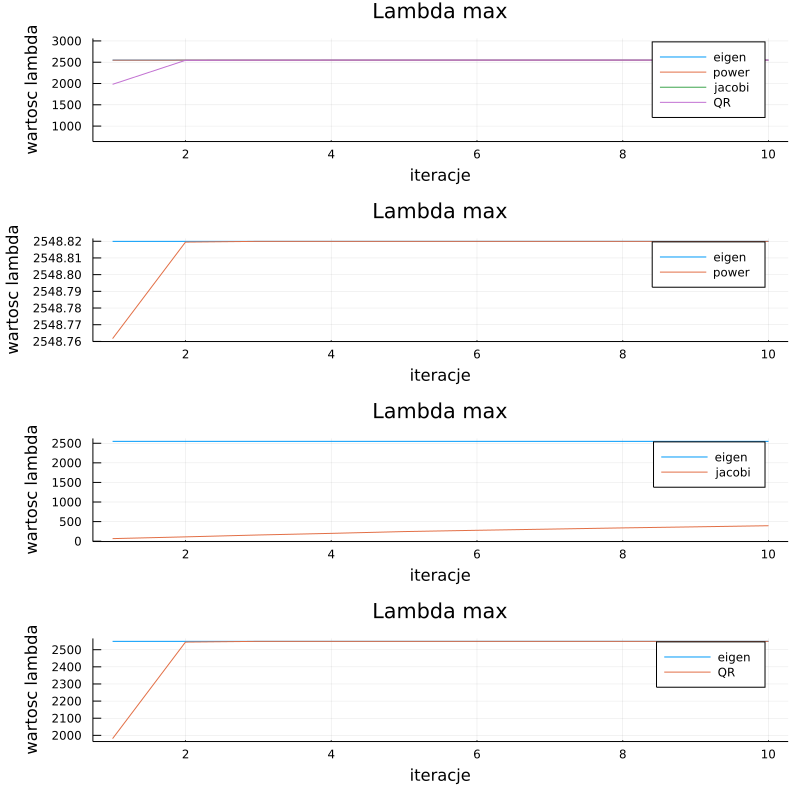

  1.091651 seconds (1.22 M allocations: 974.884 MiB, 23.17% gc time)


In [43]:
Test3 = symmetric_matrix(100)
@time plot_eigenvalues(Test3, 1, 10, true)